In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import calendar
import json
import os
import folium
from folium import plugins


In [44]:
# =========================
# 1. Cargar y combinar múltiples archivos JSON desde carpeta Datasets
# =========================
carpeta = "Datasets"
archivos = os.listdir(carpeta)
registros = []

for archivo in archivos:
    if archivo.endswith(".json"):
        ruta = os.path.join(carpeta, archivo)
        with open(ruta, "r", encoding="utf-8") as f:
            estaciones = json.load(f)
        for estacion in estaciones:
            lat = estacion.get("latitud")
            lon = estacion.get("longitud")
            nombre = estacion.get("nombre", f"Estacion_{estacion.get('codigoSerial')}")
            nombre_corto = estacion.get("nombreCorto", nombre)
            serial = estacion.get("codigoSerial")
            for entrada in estacion.get("datos", []):
                registros.append({
                    "estacion": nombre,
                    "estacion_corta": nombre_corto,
                    "codigoSerial": serial,
                    "latitud": lat,
                    "longitud": lon,
                    "fecha": entrada.get("fecha"),
                    "parametro": entrada.get("variableConsulta"),
                    "calibracion": entrada.get("valor"),
                    "valor": entrada.get("calidad")
                })

# Convertir a DataFrame plano
df = pd.DataFrame(registros)



In [45]:
# =========================
# 2. Limpieza básica
# =========================
# Asegurar tipos correctos
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df['calibracion'] = pd.to_numeric(df['calibracion'], errors='coerce')
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Filtrar solo mediciones calibradas
df_calibrado = df[df['calibracion'] != -9999].copy()

# Eliminar registros con valor nulo
df_calibrado = df_calibrado.dropna(subset=['valor', 'latitud', 'longitud'])

# Agregar columna de mes
df_calibrado['mes'] = df_calibrado['fecha'].dt.month

In [46]:
# =========================
# 3. Filtrado de calibración (datos válidos)
# =========================
df['calibracion'] = pd.to_numeric(df['calibracion'], errors='coerce')
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df_calibrado = df[df['calibracion'] != -9999].copy()



estacion
Universidad San Buenaventura                 1.199384
Exito San Antonio - Medellin                 1.136959
Estación Tráfico Centro                      1.132900
Itagüí - I.E. Concejo Municipal de Itagüí    1.125310
Itagüí - Estación de Policía Los Gómez       1.085437
Name: valor, dtype: float64

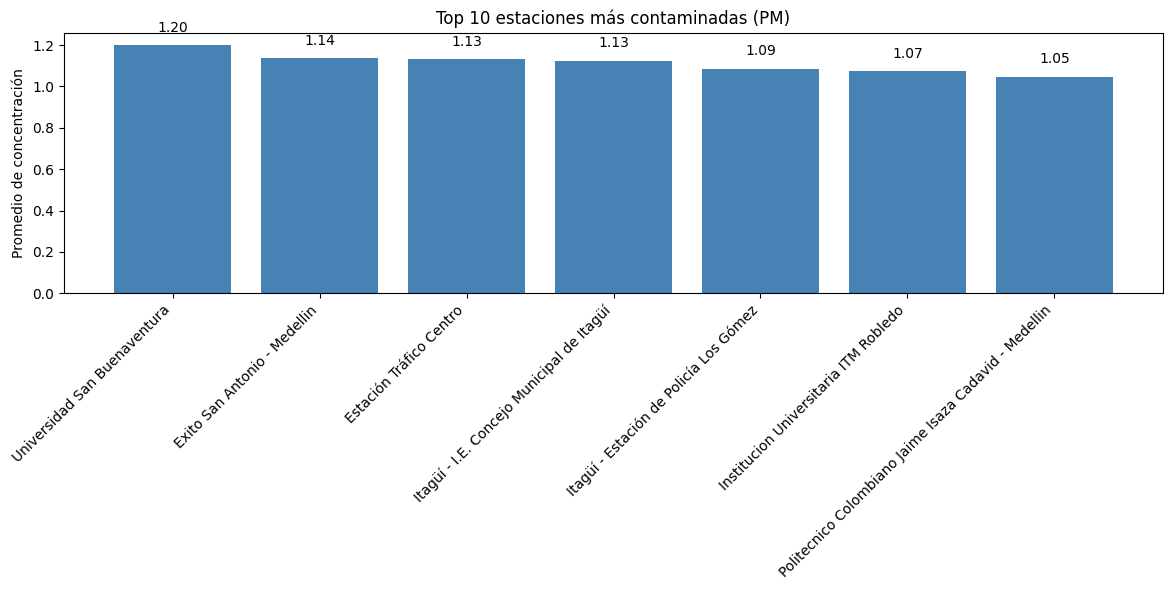

estacion
Itagüí - Casa de Justicia Itagüí                         1.294984
Institucion Universitaria ITM Robledo                    1.184155
Politecnico Colombiano Jaime Isaza Cadavid - Medellin    1.178015
_OFF-Estación Tráfico Sur                                1.077412
_OFF-Girardota - S.O.S Aburrá Norte                      1.000000
Name: valor, dtype: float64

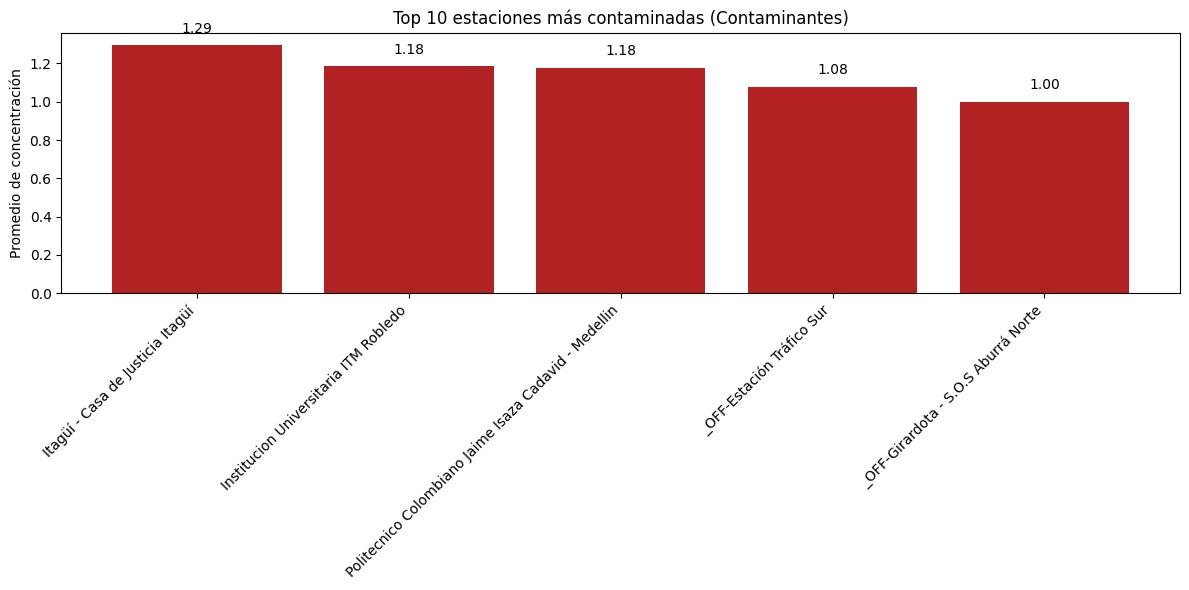

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_9412\2549439584.py:70: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_9412\2549439584.py:70: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [47]:
# =========================
# División entre contaminantes y PM
# =========================
contaminantes = ['SO2', 'NO2', 'CO', 'NO', 'O3']
pm = ['PM10', 'PM2.5', 'PM1']
df_contaminantes = df_calibrado[df_calibrado['parametro'].str.upper().isin(contaminantes)]
df_pm = df_calibrado[df_calibrado['parametro'].str.upper().isin(pm)]

# =========================
# 4. Estación más contaminada (promedio general)
# =========================
# ---- PM ----
estacion_contaminada_pm = df_pm.groupby('estacion')['valor'].mean().sort_values(ascending=False)
display(estacion_contaminada_pm.head())

plt.figure(figsize=(12, 6))
bars = plt.bar(estacion_contaminada_pm.head(10).index, estacion_contaminada_pm.head(10).values, color='steelblue')
plt.title('Top 10 estaciones más contaminadas (PM)')
plt.ylabel('Promedio de concentración')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='black')
plt.tight_layout()
plt.show()

# ---- Contaminantes ----
estacion_contaminada_contaminantes = df_contaminantes.groupby('estacion')['valor'].mean().sort_values(ascending=False)
display(estacion_contaminada_contaminantes.head())

plt.figure(figsize=(12, 6))
bars = plt.bar(estacion_contaminada_contaminantes.head(10).index, estacion_contaminada_contaminantes.head(10).values, color='firebrick')
plt.title('Top 10 estaciones más contaminadas (Contaminantes)')
plt.ylabel('Promedio de concentración')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='black')
plt.tight_layout()
plt.show()

# =========================
# 4B. Mapas en Folium: Estaciones + Calor por categoría (PM y Contaminantes)
# =========================
from folium.plugins import HeatMap

# --- Diccionario de colores ---
colores = {
    'pm25': 'green', 'pm10': 'orange', 'pm1': 'gray',
    'no2': 'blue', 'no': 'beige', 'co': 'purple', 'ozono': 'cadetblue', 'so2': 'darkred'
}

# --- Preparar datos de estaciones ---
def preparar_estaciones(df):
    media = df.groupby(['estacion_corta', 'latitud', 'longitud', 'parametro'])['valor'].mean().reset_index()
    media['parametro_normalizado'] = media['parametro'].str.lower().str.replace('.', '', regex=False)
    media['parametro_normalizado'] = media['parametro_normalizado'].replace({
        'pm25': 'pm25', 'pm10': 'pm10', 'pm1': 'pm1',
        'no2': 'no2', 'no': 'no', 'co': 'co', 'ozono': 'ozono', 'ozono': 'ozono', 'so2': 'so2'
    })
    media = media.rename(columns={'valor': 'media_calidad'})
    return media

media_pm = preparar_estaciones(df_pm)
media_cont = preparar_estaciones(df_contaminantes)

# --- Función para crear mapa folium ---
def crear_mapa_estaciones(media_df, titulo):
    m = folium.Map(location=[6.2442, -75.5812], zoom_start=11, tiles='CartoDB positron')
    popup_data = media_df.groupby(['estacion_corta', 'latitud', 'longitud']).apply(
        lambda g: "<br>".join(f"{row['parametro']}: {row['media_calidad']:.2f}" for _, row in g.iterrows())
    ).reset_index().rename(columns={0: 'popup_info'})
    for _, row in popup_data.iterrows():
        folium.CircleMarker(
            location=[row['latitud'], row['longitud']],
            radius=10,
            color='tomato',
            
            fill=True,
            fill_opacity=0.6,
            popup=folium.Popup(f"<b>{row['estacion_corta']}</b><br>{row['popup_info']}", max_width=300),
            tooltip=row['estacion_corta']
        ).add_to(m)
    return m

# --- Crear mapa de calor ---
def crear_capa_calor(df):
    puntos = df.groupby(['latitud', 'longitud'])['valor'].mean().reset_index()
    heat_data = puntos[['latitud', 'longitud', 'valor']].values.tolist()
    return HeatMap(heat_data, radius=25, blur=18, max_zoom=12, min_opacity=0.4)

# Mapa de PM
m_pm = crear_mapa_estaciones(media_pm, "Mapa PM")
crear_capa_calor(df_pm).add_to(m_pm)

# Mapa de Contaminantes
m_cont = crear_mapa_estaciones(media_cont, "Mapa Contaminantes")
crear_capa_calor(df_contaminantes).add_to(m_cont)

# Mostrar ambos mapas

m_cont


In [48]:
m_pm

Mes más contaminado: May (5)


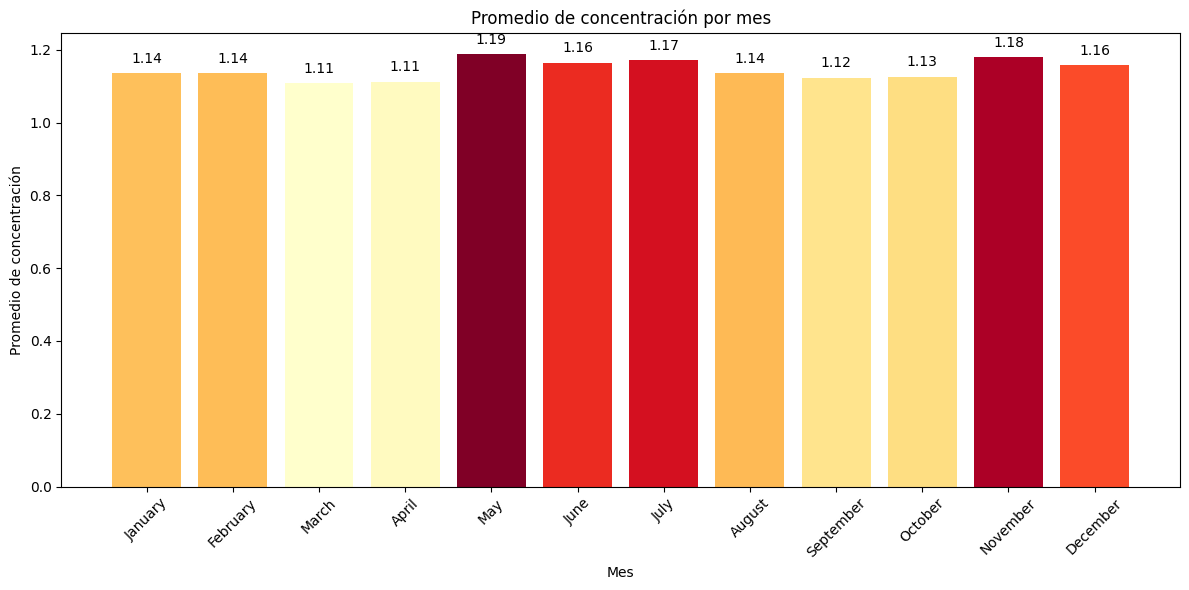

In [49]:
# =========================
# 5. Mes más contaminado
# =========================
df_calibrado['mes'] = pd.to_datetime(df_calibrado['fecha']).dt.month
mes_mas_contaminado = df_calibrado.groupby('mes')['valor'].mean().reindex(range(1, 13))
mes_peor = mes_mas_contaminado.idxmax()
nombre_mes_peor = calendar.month_name[mes_peor]
print(f"Mes más contaminado: {nombre_mes_peor} ({mes_peor})")

# Etiquetas con nombre del mes
mes_labels = [calendar.month_name[i] for i in mes_mas_contaminado.index]

# Paleta YlOrRd
import matplotlib.cm as cm
norm = plt.Normalize(mes_mas_contaminado.min(), mes_mas_contaminado.max())
colors = [cm.YlOrRd(norm(val)) for val in mes_mas_contaminado.values]

plt.figure(figsize=(12, 6))
bars = plt.bar(mes_labels, mes_mas_contaminado.values, color=colors)
plt.title('Promedio de concentración por mes')
plt.ylabel('Promedio de concentración')
plt.xlabel('Mes')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='black')
plt.tight_layout()
plt.show()


estacion
_OFF-Caldas - Corporacion Universitaria Lasallista    1.856954
Universidad de Medellin                               1.688712
Medellín, El Poblado - Tanques La Ye EPM              1.551212
La Estrella - Hospital                                1.381617
Itagüí - I.E. Concejo Municipal de Itagüí             1.367416
Name: valor, dtype: float64

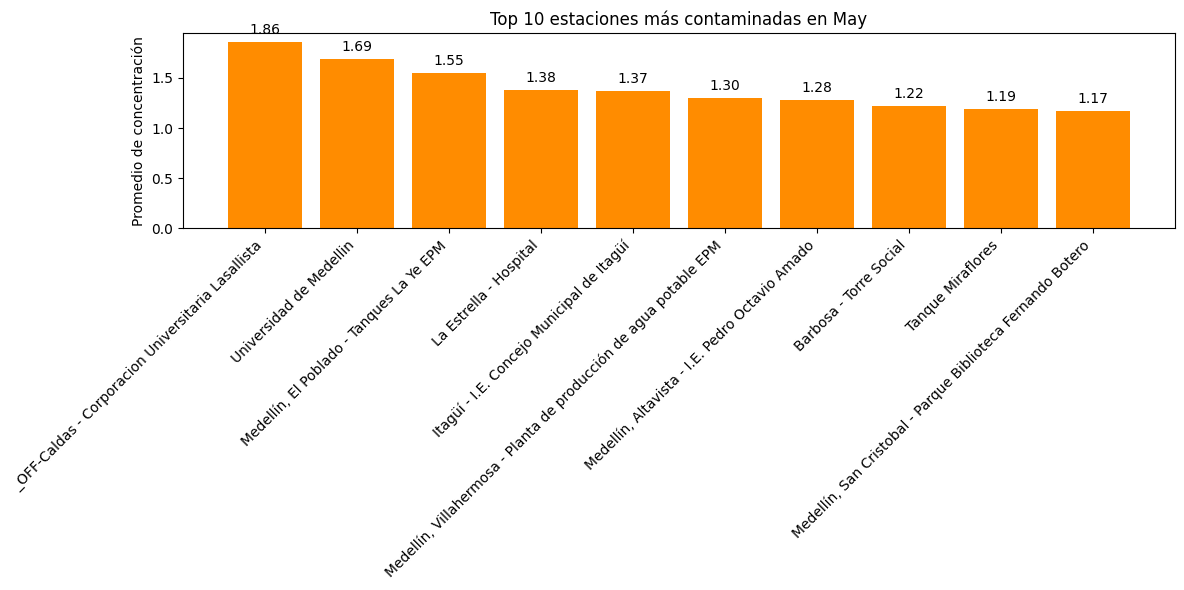

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_9412\3164475753.py:20: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,estacion,parametro,valor_promedio
0,Barbosa - Torre Social,pm25,1.166724
1,Bello - I.E. Fernando Vélez,pm25,1.088395
2,Caldas - E U Joaquín Aristizabal,pm25,1.089749
3,Copacabana - Ciudadela Educativa La Vida,pm25,1.083562
4,Envigado - E.S.E. Santa Gertrudis,pm25,1.081400


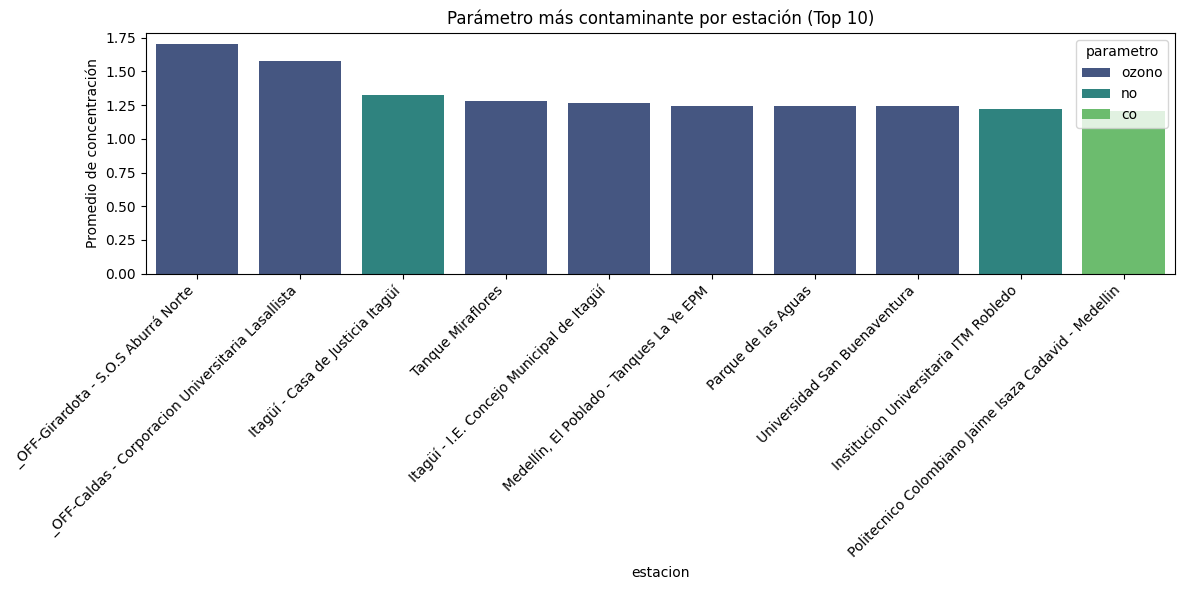

In [50]:
# =========================
# 6. Estación más contaminada en el mes más contaminado
# =========================
df_mes_peor = df_calibrado[df_calibrado['mes'] == mes_peor]
estacion_peor_en_mes = df_mes_peor.groupby('estacion')['valor'].mean().sort_values(ascending=False)
display(estacion_peor_en_mes.head())

plt.figure(figsize=(12, 6))
bars = plt.bar(estacion_peor_en_mes.head(10).index, estacion_peor_en_mes.head(10).values, color='darkorange')
plt.title(f'Top 10 estaciones más contaminadas en {nombre_mes_peor}')
plt.ylabel('Promedio de concentración')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='black')
plt.tight_layout()
plt.show()

# Parámetro más contaminante por estación
max_param_por_estacion = df_calibrado.groupby('estacion').apply(
    lambda g: g.groupby('parametro')['valor'].mean().sort_values(ascending=False).head(1)
).reset_index().rename(columns={'level_1': 'parametro', 'valor': 'valor_promedio'})
display(max_param_por_estacion.head())

# Gráfico de barras de los parámetros más contaminantes por estación
plt.figure(figsize=(12, 6))
sns.barplot(data=max_param_por_estacion.sort_values('valor_promedio', ascending=False).head(10), 
            x='estacion', y='valor_promedio', hue='parametro', palette='viridis')
plt.title('Parámetro más contaminante por estación (Top 10)')
plt.ylabel('Promedio de concentración')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


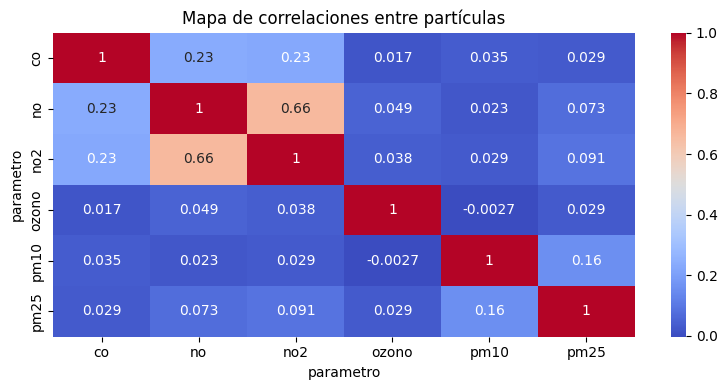

In [51]:
# =========================
# 7. Mapa de correlaciones
# =========================
pivot_corr = df_calibrado.pivot_table(index='fecha', columns='parametro', values='valor', aggfunc='mean')
# Eliminar columnas completamente vacías o con muchos nulos
pivot_corr = pivot_corr.dropna(axis=1, thresh=int(0.5 * len(pivot_corr)))
correlation_matrix = pivot_corr.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=correlation_matrix.isnull())
plt.title('Mapa de correlaciones entre partículas')
plt.tight_layout()
plt.show()



,parametro,porcentaje_valido
0,pm25,87.445443
1,ozono,70.021180
2,pm10,68.061865
3,no2,54.988830
4,no,54.830662
5,co,31.370087


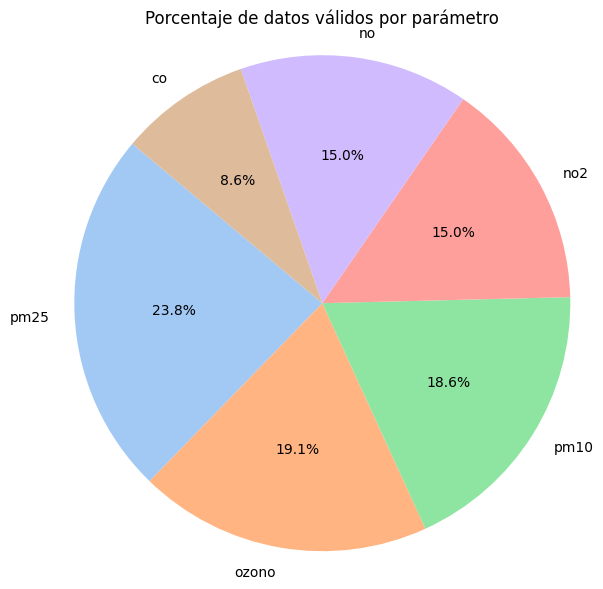

In [52]:
# =========================
# 8. Conteo de datos válidos por parámetro
# =========================
total_por_param = df.groupby('parametro').size()
calibrados_por_param = df_calibrado.groupby('parametro').size()
porcentaje_calibrado = (calibrados_por_param / total_por_param * 100).sort_values(ascending=False).reset_index()
porcentaje_calibrado.columns = ['parametro', 'porcentaje_valido']

# Eliminar posibles NaN (sin datos calibrados)
porcentaje_calibrado = porcentaje_calibrado.dropna()

porcentaje_calibrado = porcentaje_calibrado[porcentaje_calibrado['parametro'].str.lower() != 'so2']


display(porcentaje_calibrado)

# Gráfico de torta
plt.figure(figsize=(6, 6))
plt.pie(porcentaje_calibrado['porcentaje_valido'], 
        labels=porcentaje_calibrado['parametro'], 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=sns.color_palette('pastel'))
plt.title('Porcentaje de datos válidos por parámetro')
plt.axis('equal')
plt.tight_layout()
plt.savefig('grafico_pastel_datos_validos.png')
plt.show()

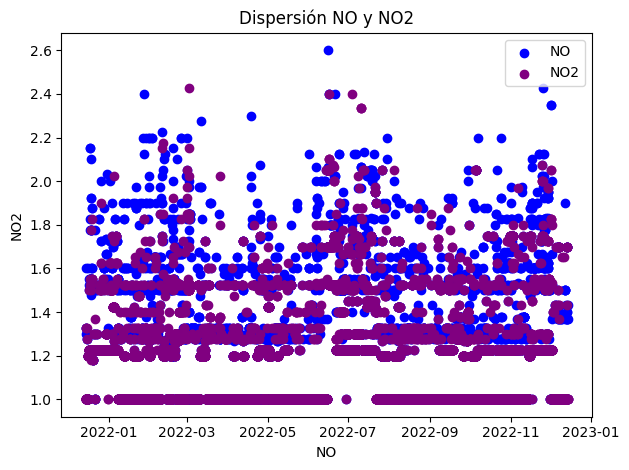

In [53]:
# =========================
# 10. Dispersión 2D
# =========================

import matplotlib.pyplot as plt

plt.scatter(pivot_corr.index, pivot_corr['no'], color='blue', label='NO')
plt.scatter(pivot_corr.index, pivot_corr['no2'], color='purple', label='NO2')


plt.xlabel('NO')
plt.ylabel('NO2')
plt.title('Dispersión NO y NO2')
plt.legend()
plt.tight_layout()

plt.savefig('dispersion_novsno2.png')
plt.show()




In [54]:
# =========================
# 11. Dispersión 3D
# =========================
fig = px.scatter_3d(pivot_corr.reset_index(), x='pm25', y='no2', z='ozono', color='pm10')
fig.update_layout(title='Dispersión 3D entre partículas')
fig.show()


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_9412\2098006308.py:8: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



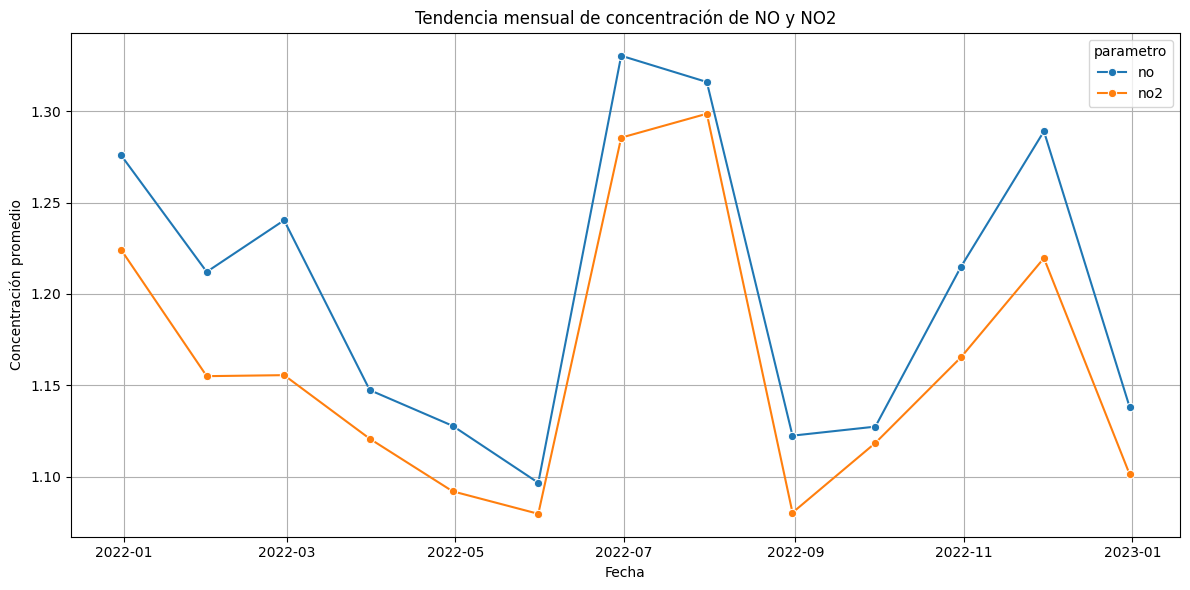

In [55]:
# =========================
# 9. Tendencia mensual de NO y NO2
# =========================
df_calibrado['fecha'] = pd.to_datetime(df_calibrado['fecha'])
df_tendencia = df_calibrado[df_calibrado['parametro'].isin(['no', 'no2'])]

df_tendencia_mensual = (
    df_tendencia.groupby([pd.Grouper(key='fecha', freq='M'), 'parametro'])['valor']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_tendencia_mensual, x='fecha', y='valor', hue='parametro', marker='o')
plt.title('Tendencia mensual de concentración de NO y NO2')
plt.ylabel('Concentración promedio')
plt.xlabel('Fecha')
plt.grid(True)
plt.tight_layout()
plt.show()


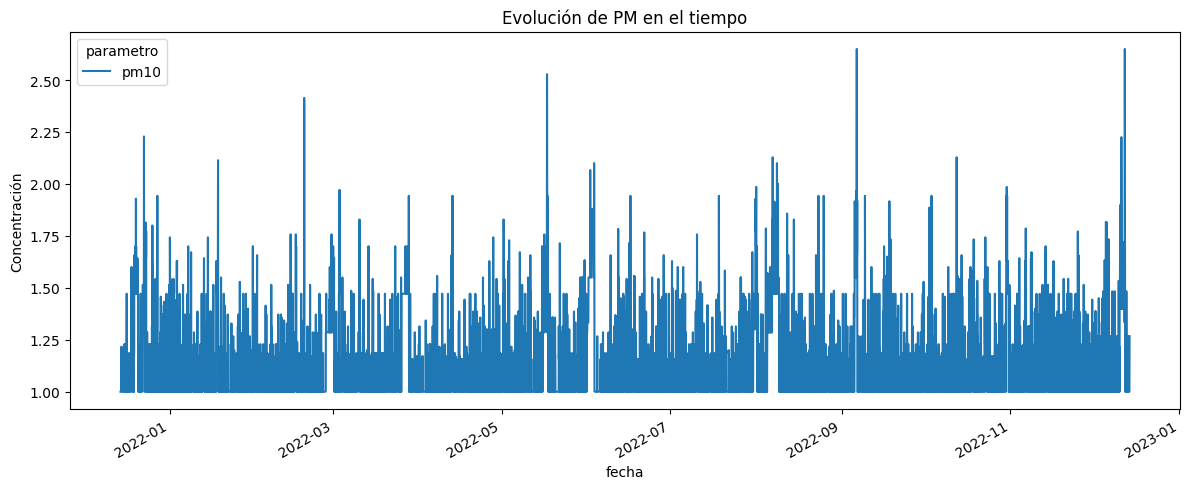

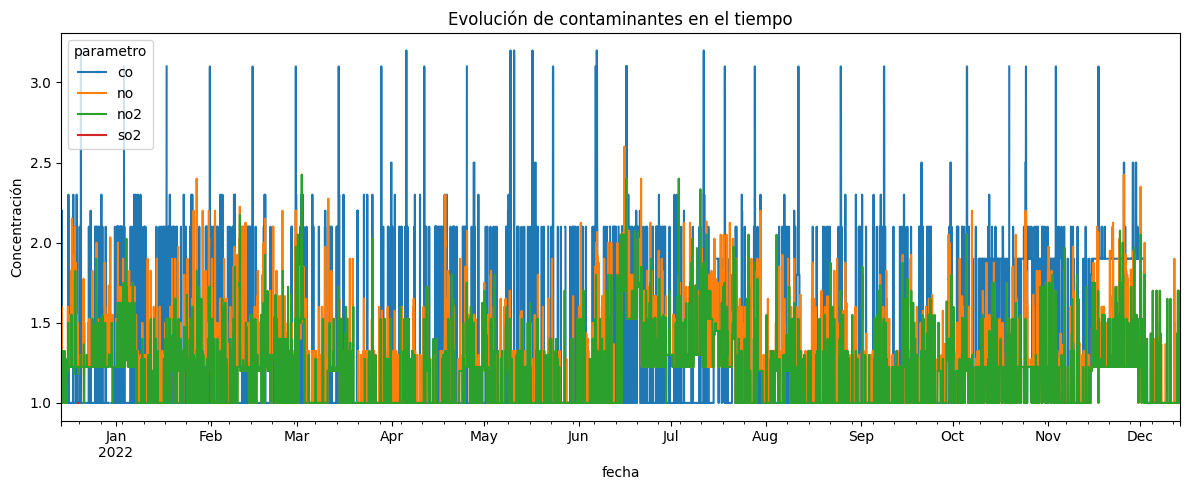

In [56]:
# =========================
# 12. Evolución temporal
# =========================
df_pm.groupby(['fecha', 'parametro'])['valor'].mean().unstack().plot(figsize=(12, 5))
plt.title('Evolución de PM en el tiempo')
plt.ylabel('Concentración')
plt.tight_layout()
plt.show()

df_contaminantes.groupby(['fecha', 'parametro'])['valor'].mean().unstack().plot(figsize=(12, 5))
plt.title('Evolución de contaminantes en el tiempo')
plt.ylabel('Concentración')
plt.tight_layout()
plt.show()

In [57]:
# =========================
# 13. Coincidencias de estaciones por contaminante
# =========================
contaminantes_set = set(contaminantes)
parametros_por_estacion = df_calibrado.groupby('estacion')['parametro'].apply(lambda x: set(x.str.upper()))

# Crear diccionario: contaminante -> lista de estaciones que lo miden
estaciones_por_contaminante = {
    contaminante: parametros_por_estacion[parametros_por_estacion.apply(lambda x: contaminante in x)].index.tolist()
    for contaminante in contaminantes_set
}

# Convertir a DataFrame para visualizar
from collections import defaultdict
contaminante_estaciones_df = pd.DataFrame([(k, est) for k, v in estaciones_por_contaminante.items() for est in v], columns=['parametro', 'estacion'])
display(contaminante_estaciones_df.groupby('parametro')['estacion'].nunique())

# Elegir estaciones que midan al menos 3 contaminantes
conteo_por_estacion = contaminante_estaciones_df.groupby('estacion')['parametro'].nunique()
estaciones_comunes = conteo_por_estacion[conteo_por_estacion >= 3].index.tolist()
df_8_estaciones = df_calibrado[df_calibrado['estacion'].isin(estaciones_comunes[:8])]

contaminantes_set = set(contaminantes)
parametros_por_estacion = df_calibrado.groupby('estacion')['parametro'].apply(lambda x: set(x.str.upper()))
estaciones_con_todos_contaminantes = parametros_por_estacion[parametros_por_estacion.apply(lambda x: contaminantes_set.issubset(x))].index
df_8_estaciones = df_calibrado[df_calibrado['estacion'].isin(estaciones_con_todos_contaminantes[:8])]




parametro
CO     1
NO     5
NO2    5
SO2    1
Name: estacion, dtype: int64

In [58]:
# =========================
# 13. Estaciones que miden NO y NO2
# =========================
estaciones_no = set(estaciones_por_contaminante.get('NO', []))
estaciones_no2 = set(estaciones_por_contaminante.get('NO2', []))

estaciones_no_no2 = list(estaciones_no & estaciones_no2)
df_8_estaciones = df_calibrado[
    (df_calibrado['estacion'].isin(estaciones_no_no2)) &
    (df_calibrado['parametro'].str.upper().isin(['NO', 'NO2']))
]



In [59]:
# =========================
# 14. Radar por estación (solo NO y NO2)
# =========================
radar_df = df_8_estaciones.groupby(['estacion', 'parametro'])['valor'].mean().unstack()
fig = go.Figure()
for estacion in radar_df.index:
    fig.add_trace(go.Scatterpolar(
        r=radar_df.loc[estacion].values,
        theta=radar_df.columns,
        fill='toself',
        name=estacion
    ))
fig.update_layout(title='Radar de NO y NO2 por estación', polar=dict(radialaxis=dict(visible=True)), showlegend=True)
fig.show()




In [60]:
# =========================
# 14. Dispersión 3D por estación (NO y NO2)
# =========================
from plotly.express.colors import qualitative

radar_df = df_8_estaciones.groupby(['estacion', 'parametro'])['valor'].mean().unstack().reset_index()
fig = go.Figure()
colors = qualitative.Plotly

for i, row in radar_df.iterrows():
    fig.add_trace(go.Scatter3d(
        x=[row['no']],
        y=[row['no2']],
        z=[0],
        mode='markers+text',
        marker=dict(size=8, color=colors[i % len(colors)]),
        text=row['estacion'],
        textposition='top center',
        name=row['estacion']
    ))

fig.update_layout(
    title='Visualización 3D de NO y NO2 por estación',
    width=1000,
    height=700,
    scene=dict(
        xaxis_title='NO',
        yaxis_title='NO2',
        zaxis_title='',
    ),
    showlegend=False
)
fig.show()

In [61]:
# Agrupación por estación y parámetro
df_estaciones = df_calibrado.groupby(
    ['estacion_corta', 'latitud', 'longitud', 'parametro']
)['valor'].mean().reset_index().rename(columns={'valor': 'media_calidad'})

# Normalizar nombres de parámetros
df_estaciones['parametro_normalizado'] = (
    df_estaciones['parametro']
    .str.lower()
    .str.replace('.', '', regex=False)
    .replace({
        'pm25': 'pm25',
        'pm10': 'pm10',
        'pm1': 'pm1',
        'no2': 'no2',
        'no': 'no',
        'co': 'co',
        'o3': 'ozono',
        'ozono': 'ozono',
        'so2': 'so2'
    })
)

# =========================
# Mapa avanzado de estaciones con Folium
# =========================
import pandas as pd
import folium
from folium import FeatureGroup, LayerControl
from folium.plugins import MarkerCluster, HeatMap
import branca.colormap as cm

# Diccionario de colores por parámetro
colores = {
    'pm25': 'green',
    'pm10': 'orange',
    'no2': 'blue',
    'no': 'lightblue',
    'co': 'purple',
    'ozono': 'cadetblue',
    'so2': 'darkred',
    'pm1': 'gray'
}

# Normalizar nombres de parámetros
if 'parametro_normalizado' not in df_estaciones.columns:
    df_estaciones['parametro_normalizado'] = (
        df_estaciones['parametro']
        .str.lower()
        .str.replace('.', '', regex=False)
    )
    df_estaciones['parametro_normalizado'] = df_estaciones['parametro_normalizado'].replace({
        'pm25': 'pm25', 'pm10': 'pm10', 'pm1': 'pm1',
        'no2': 'no2', 'no': 'no', 'co': 'co',
        'o3': 'ozono', 'ozono': 'ozono', 'so2': 'so2'
    })

# Mapa base
m = folium.Map(location=[6.2442, -75.5812], zoom_start=11, tiles='CartoDB positron')

# 1. Capas por parámetro con colores específicos
for param in df_estaciones['parametro_normalizado'].unique():
    capa = FeatureGroup(name=param.upper())
    subset = df_estaciones[df_estaciones['parametro_normalizado'] == param]
    color = colores.get(param, 'black')

    for _, row in subset.iterrows():
        folium.CircleMarker(
            location=[row['latitud'], row['longitud']],
            radius=5 + (row['media_calidad'] / 10),
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=folium.Popup(f"{row['estacion_corta']}<br>{param.upper()}: {row['media_calidad']:.2f}", max_width=250),
            tooltip=row['estacion_corta']
        ).add_to(capa)

    capa.add_to(m)

# 2. Heatmap general
heat_data = [[row['latitud'], row['longitud'], row['media_calidad']] for _, row in df_estaciones.iterrows()]
HeatMap(heat_data, name='Mapa de calor').add_to(m)

# 3. Clúster de estaciones
cluster = MarkerCluster(name='Estaciones agrupadas').add_to(m)
for _, row in df_estaciones.iterrows():
    folium.Marker(
        location=[row['latitud'], row['longitud']],
        popup=f"{row['estacion_corta']}<br>{row['parametro']}: {row['media_calidad']:.2f}"
    ).add_to(cluster)

# 4. Leyenda de colores dinámicos (colormap por concentración)
min_val = df_estaciones['media_calidad'].min()
max_val = df_estaciones['media_calidad'].max()
colormap = cm.linear.YlOrRd_09.scale(min_val, max_val)
colormap.caption = 'Nivel de concentración'
colormap.add_to(m)

# 5. Control de capas
LayerControl(collapsed=False).add_to(m)

# 6. Guardar mapa
m.save("mapa_avanzado_calidad_aire.html")
print("Mapa guardado como 'mapa_avanzado_calidad_aire.html'")


Mapa guardado como 'mapa_avanzado_calidad_aire.html'


In [62]:
# Asegurarse de que 'fecha' sea tipo datetime
df_calibrado['fecha'] = pd.to_datetime(df_calibrado['fecha'], errors='coerce')

# Crear columna de tipo de día
df_calibrado['tipo_dia'] = df_calibrado['fecha'].dt.dayofweek.apply(lambda x: 'Fin de semana' if x >= 5 else 'Semana')


# Por tipo de día y estación
promedios_dia = df_calibrado.groupby(['tipo_dia', 'estacion'])['valor'].mean().reset_index()
promedios_dia = promedios_dia.pivot(index='estacion', columns='tipo_dia', values='valor')
promedios_dia = promedios_dia.dropna()
display(promedios_dia.head())


tipo_dia,Fin de semana,Semana
estacion,,
Barbosa - Torre Social,1.160295,1.169268
Bello - I.E. Fernando Vélez,1.086799,1.089032
Caldas - E U Joaquín Aristizabal,1.056410,1.103043
Copacabana - Ciudadela Educativa La Vida,1.047799,1.097858
Envigado - E.S.E. Santa Gertrudis,1.064048,1.088334


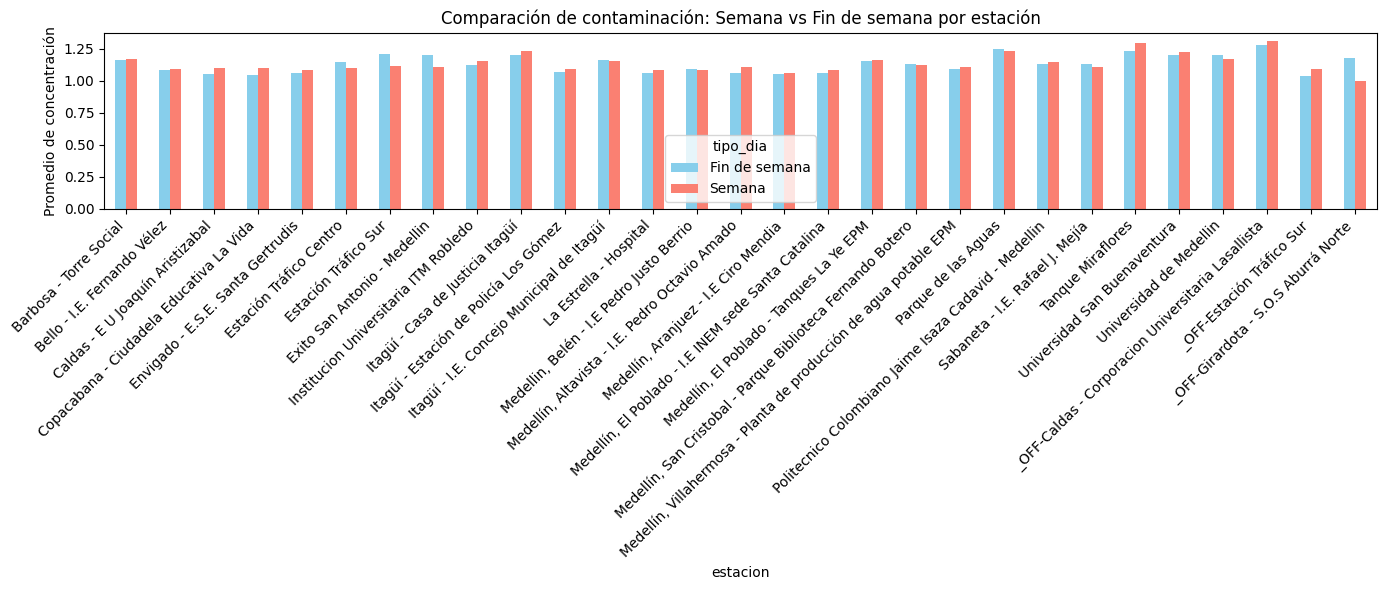

In [63]:
promedios_dia.plot(kind='bar', figsize=(14, 6), color=['skyblue', 'salmon'])
plt.title('Comparación de contaminación: Semana vs Fin de semana por estación')
plt.ylabel('Promedio de concentración')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [64]:
limites_oms = {
    'PM2.5': 15,
    'PM10': 45,
    'NO2': 25,
    'SO2': 40,
    'CO': 4,     # en mg/m³
    'OZONO': 100    # 8 horas, pero lo usamos como aproximado diario
}



In [65]:
# =========================
# División entre contaminantes y PM
# =========================
contaminantes = ['SO2', 'NO2', 'CO', 'NO', 'OZONO']
pm = ['PM10', 'PM2.5', 'PM1']
df_contaminantes = df_calibrado[df_calibrado['parametro'].str.upper().isin(contaminantes)]
df_pm = df_calibrado[df_calibrado['parametro'].str.upper().isin(pm)]

# =========================
# Clasificación de calidad del aire según OMS
# =========================
def clasificar_calidad_aire(valor, contaminante):
    if pd.isna(valor):
        return "Sin datos"

    contaminante = contaminante.lower()

    if contaminante == 'pm2.5' or contaminante == 'pm25':
        if valor <= 12: return "Bueno"
        elif valor <= 35.4: return "Aceptable"
        elif valor <= 55.4: return "No saludable sensibles"
        elif valor <= 150.4: return "No saludable"
        elif valor <= 250.4: return "Muy no saludable"
        else: return "Peligroso"

    elif contaminante == 'pm10':
        if valor <= 54: return "Bueno"
        elif valor <= 154: return "Aceptable"
        elif valor <= 254: return "No saludable sensibles"
        elif valor <= 354: return "No saludable"
        elif valor <= 424: return "Muy no saludable"
        else: return "Peligroso"

    elif contaminante == 'co':
        if valor <= 4.4: return "Bueno"
        elif valor <= 9.4: return "Aceptable"
        elif valor <= 12.4: return "No saludable sensibles"
        elif valor <= 15.4: return "No saludable"
        elif valor <= 30.4: return "Muy no saludable"
        else: return "Peligroso"

    elif contaminante == 'ozono':
        if valor <= 0.054: return "Bueno"
        elif valor <= 0.070: return "Aceptable"
        elif valor <= 0.085: return "No saludable sensibles"
        elif valor <= 0.105: return "No saludable"
        elif valor <= 0.200: return "Muy no saludable"
        else: return "Peligroso"

    elif contaminante == 'no2':
        if valor <= 0.053: return "Bueno"
        elif valor <= 0.100: return "Aceptable"
        elif valor <= 0.360: return "No saludable sensibles"
        elif valor <= 0.649: return "No saludable"
        elif valor <= 1.249: return "Muy no saludable"
        else: return "Peligroso"

    elif contaminante == 'so2':
        if valor <= 0.035: return "Bueno"
        elif valor <= 0.075: return "Aceptable"
        elif valor <= 0.185: return "No saludable sensibles"
        elif valor <= 0.304: return "No saludable"
        elif valor <= 0.604: return "Muy no saludable"
        else: return "Peligroso"

    elif contaminante == 'no' or contaminante == 'pm1':
        return "Sin estándar oficial"

    else:
        return "Contaminante desconocido"

# --- Color por categoría ---
def color_por_categoria(categoria):
    colores = {
        "Bueno": "green",
        "Aceptable": "yellow",
        "No saludable sensibles": "orange",
        "No saludable": "red",
        "Muy no saludable": "purple",
        "Peligroso": "maroon",
        "Sin datos": "gray",
        "Sin estándar oficial": "blue",
        "Contaminante desconocido": "black"
    }
    return colores.get(categoria, "black")

# --- Añadir leyenda al mapa ---
def agregar_leyenda(mapa):
    leyenda_html = '''
    <div style="position: fixed; 
                bottom: 30px; left: 30px; width: 240px; height: 260px; 
                background-color: white; z-index:9999; font-size:14px;
                border:2px solid grey; border-radius:10px; padding: 10px">
    <b>Leyenda de calidad del aire</b><br>
    <i style="background:green;width:10px;height:10px;display:inline-block"></i> Bueno<br>
    <i style="background:yellow;width:10px;height:10px;display:inline-block"></i> Aceptable<br>
    <i style="background:orange;width:10px;height:10px;display:inline-block"></i> No saludable sensibles<br>
    <i style="background:red;width:10px;height:10px;display:inline-block"></i> No saludable<br>
    <i style="background:purple;width:10px;height:10px;display:inline-block"></i> Muy no saludable<br>
    <i style="background:maroon;width:10px;height:10px;display:inline-block"></i> Peligroso<br>
    <i style="background:gray;width:10px;height:10px;display:inline-block"></i> Sin datos<br>
    <i style="background:blue;width:10px;height:10px;display:inline-block"></i> Sin estándar oficial<br>
    </div>'''
    mapa.get_root().html.add_child(folium.Element(leyenda_html))

# =========================
# Mapas por categoría (PM y Contaminantes)
# =========================
from folium.plugins import HeatMap

# --- Media por estación ---
def media_estacion(df):
    return df[df['calibracion'] != -9999].groupby(
        ['codigoSerial', 'estacion_corta', 'parametro', 'latitud', 'longitud']
    )['valor'].mean().reset_index()

media_pm = media_estacion(df_pm)
media_cont = media_estacion(df_contaminantes)

# --- Crear mapa agrupando parámetros por estación ---
def crear_mapa_agrupado(media_df, titulo):
    mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)
    estaciones = media_df.groupby(['codigoSerial', 'estacion_corta', 'latitud', 'longitud'])

    for (codigo, nombre, lat, lon), grupo in estaciones:
        popup_text = f"<b>{nombre}</b><br>"
        peor_categoria = "Bueno"
        peor_color = "green"
        for _, row in grupo.iterrows():
            param = row['parametro'].lower()
            if param == 'o3':
                param = 'ozono'
            categoria = clasificar_calidad_aire(row['valor'], param)
            color = color_por_categoria(categoria)
            popup_text += f"{row['parametro']}: {row['valor']:.2f} → {categoria}<br>"

            # Asignar el color de la peor categoría (más peligrosa)
            niveles = ["Bueno", "Aceptable", "No saludable sensibles", "No saludable", "Muy no saludable", "Peligroso"]
            if categoria in niveles and niveles.index(categoria) > niveles.index(peor_categoria):
                peor_categoria = categoria
                peor_color = color

        folium.CircleMarker(
            location=[lat, lon],
            radius=10,
            popup=folium.Popup(popup_text, max_width=300),
            color=peor_color,
            fill=True,
            fill_color=peor_color,
            fill_opacity=0.7
        ).add_to(mapa)

    agregar_leyenda(mapa)
    return mapa

# --- Generar mapas ---
mapa_pm = crear_mapa_agrupado(media_pm, "Mapa PM Agrupado")
mapa_cont = crear_mapa_agrupado(media_cont, "Mapa Contaminantes Agrupado")

# Mostrar ambos mapas
from IPython.display import display
print("\n🗺️ Mapa PM Agrupado (según categoría OMS)")
display(mapa_pm)
print("\n🗺️ Mapa Contaminantes Agrupado (según categoría OMS)")
display(mapa_cont)



🗺️ Mapa PM Agrupado (según categoría OMS)



🗺️ Mapa Contaminantes Agrupado (según categoría OMS)


In [66]:
# Convertir fecha a datetime
df_calibrado['fecha'] = pd.to_datetime(df_calibrado['fecha'])

# Días especiales en Medellín
dias_especiales = {
    "Año Nuevo": ['2021-01-01', '2022-01-01'],
    "Día sin carro": ['2021-04-22', '2022-04-21'],
    "Feria de las Flores": ['2021-08-07', '2022-08-06'],  # Se puede añadir más fechas si tienes el rango
    "Halloween": ['2021-10-31', '2022-10-31'],
    "Navidad": ['2021-12-25', '2022-12-25'],
    "Velitas": ['2021-12-07', '2022-12-07']
}

In [67]:
# Crear lista plana con todos los días especiales
fechas_especiales = [pd.to_datetime(fecha) for fechas in dias_especiales.values() for fecha in fechas]

# Crear nueva columna 'tipo_dia' en df_calibrado
df_calibrado['tipo_dia'] = df_calibrado['fecha'].apply(lambda x: 'Especial' if x in fechas_especiales else 'Normal')

# Agrupar por contaminante y tipo de día y calcular promedio
comparacion = df_calibrado.groupby(['parametro', 'tipo_dia'])['valor'].mean().unstack()


comparacion['diferencia'] = comparacion['Especial'] - comparacion['Normal']
display(comparacion.sort_values('diferencia', ascending=False))




tipo_dia,Especial,Normal,diferencia
parametro,,,
pm10,1.263378,1.114999,0.148379
pm25,1.204717,1.096939,0.107778
co,1.225000,1.207062,0.017938
ozono,1.245946,1.263412,-0.017466
no,1.172727,1.202434,-0.029707
no2,1.122727,1.160924,-0.038197
so2,NaN,1.000000,NaN


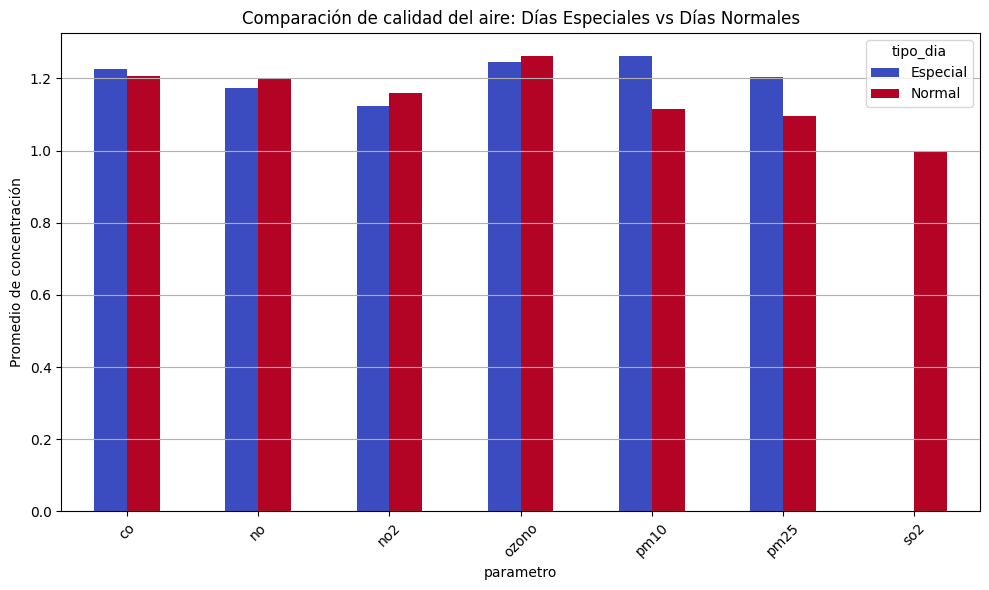

In [68]:
comparacion[['Especial', 'Normal']].plot(kind='bar', figsize=(10,6), colormap='coolwarm')
plt.title('Comparación de calidad del aire: Días Especiales vs Días Normales')
plt.ylabel('Promedio de concentración')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [69]:
def clasificar_dia(fecha):
    fecha_str = fecha.strftime('%Y-%m-%d')
    for nombre, fechas in dias_especiales.items():
        if fecha_str in fechas:
            return nombre
    if fecha.weekday() >= 5:
        return "Fin de semana"
    return "Día normal"

df_calibrado['tipo_dia'] = df_calibrado['fecha'].apply(clasificar_dia)
promedios_tipo_dia = df_calibrado[df_calibrado['calibracion'] != -9999].groupby(
    ['tipo_dia', 'parametro']
)['valor'].mean().reset_index()


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_9412\1919867997.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



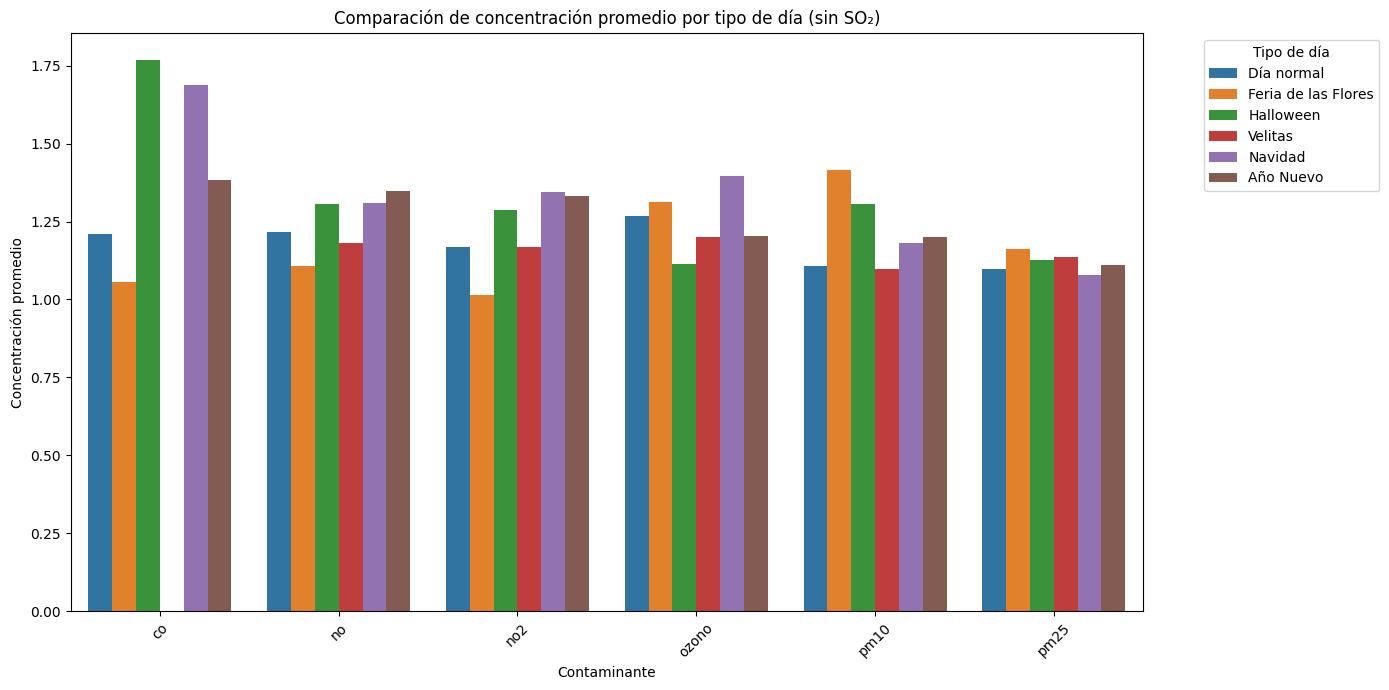

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Orden deseado para mostrar los tipos de día
orden_tipo_dia = [
    "Día normal", 
    "Feria de las Flores", 
    "Halloween", 
    "Velitas", 
    "Navidad", 
    "Año Nuevo"
]

# Excluir SO2
df_sin_so2 = promedios_tipo_dia[promedios_tipo_dia['parametro'].str.upper() != 'SO2']

# Aplicar orden personalizado a la columna tipo_dia
df_sin_so2['tipo_dia'] = pd.Categorical(
    df_sin_so2['tipo_dia'],
    categories=orden_tipo_dia,
    ordered=True
)

# Ordenar por parámetro y tipo de día
df_sin_so2 = df_sin_so2.sort_values(['parametro', 'tipo_dia'])

# Gráfica
plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_sin_so2,
    x='parametro',
    y='valor',
    hue='tipo_dia'
)
plt.title("Comparación de concentración promedio por tipo de día (sin SO₂)")
plt.ylabel("Concentración promedio")
plt.xlabel("Contaminante")
plt.xticks(rotation=45)
plt.legend(title="Tipo de día", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()





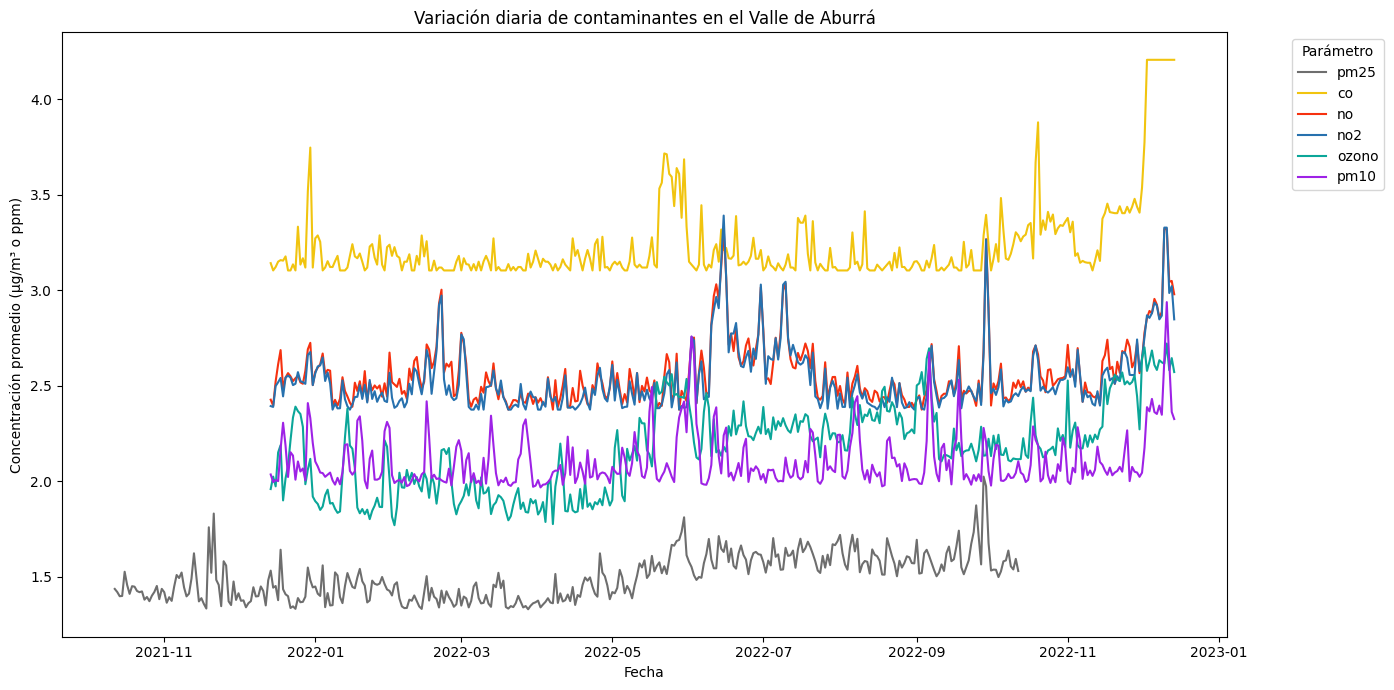

In [71]:

# Asegúrate de que la fecha esté en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Filtrar para eliminar SO2
# Filtrar para eliminar SO2 y PM1 (ignorando mayúsculas)
df_filtrado = df[~df['parametro'].str.lower().isin(['so2', 'pm1'])]



# Agrupar por fecha y parámetro: promedio diario
df_diario = df_filtrado.groupby([pd.Grouper(key='fecha', freq='D'), 'parametro'])['valor'].mean().reset_index()

# Colores contrastantes
palette = sns.color_palette("tab10", n_colors=df_diario['parametro'].nunique())


palette = [
    "#6E6E6E",  # Rojo anaranjado brillante
    "#F1C40F",  # Azul intenso
    "#F6310F",  # Verde esmeralda
    "#2771AE",  # Púrpura fuerte
    "#0BA699",  # Amarillo dorado
    "#9E22E6",  # Naranja vivo
]


# Graficar
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_diario, x='fecha', y='valor', hue='parametro', palette=palette)
plt.title('Variación diaria de contaminantes en el Valle de Aburrá')
plt.xlabel('Fecha')
plt.ylabel('Concentración promedio (µg/m³ o ppm)')
plt.legend(title='Parámetro', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()